# Esempi di Catene composte

In [1]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda, RunnableParallel
from langchain_core.prompts import PromptTemplate
from typing import Dict, Any
import json

In [2]:
# Definizione dei prompt
history_prompt = PromptTemplate.from_template("Riassumi brevemente la storia di {input}")
story_prompt = PromptTemplate.from_template("Inventa una breve storia in italiano ambientata in {input}")

In [3]:
# Creazione del connettore al LLM
from langchain.chat_models import init_chat_model

llm = init_chat_model("openai:gpt-4o-mini")

# Nota: per i modelli OpenAI disponibili e relativi princing, si può fare riferimento qui:
# https://openai.com/api/pricing/

###  Catena step by step

In [4]:
history_chain = history_prompt | llm | StrOutputParser()

story_chain = story_prompt | llm | StrOutputParser()

In [5]:
history_prompt.invoke({"input":"Lecce"}).text

'Riassumi brevemente la storia di Lecce'

In [6]:
story_prompt.invoke({"input":"Lecce"}).text

'Inventa una breve storia in italiano ambientata in Lecce'

In [7]:
history_res = history_chain.invoke({"input":"Lecce"})

story_res = story_chain.invoke({"input":"Lecce"})

print(history_res)
print("\n---\n")
print(story_res)

Lecce è una città situata nel sud Italia, nella regione della Puglia, con una storia che risale all'antichità. Fondata dai messapi, una popolazione indigenza, la città divenne un importante centro commerciale in epoca romana, conosciuta con il nome di Lupiae. Durante il periodo romano, Lecce ospitò molte costruzioni significative, tra cui un anfiteatro e un teatro, alcune delle quali sono ancora visibili.

Con la caduta dell'Impero Romano, Lecce passò sotto il controllo di vari popoli, inclusi i Bizantini e i Normanni. Nel Medioevo, la città si sviluppò ulteriormente, con la costruzione di chiese e palazzi in stile romanico. 

Il Rinascimento segnò un periodo di grande fioritura culturale per Lecce, che divenne famosa per la sua architettura barocca, caratterizzata dall'uso di pietra leccese, un materiale locale. Durante il periodo della dominazione spagnola, Lecce continuò a prosperare, consolidando il suo ruolo di centro culturale e religioso.

Nel XIX secolo, Lecce si sviluppò ulter

In [8]:
# Creazione di un prompt template per combinare i risultati
combine_prompt = PromptTemplate.from_template(
    "Notizie storiche: {history}\nI fatti: {story}\n\nCombina i fatti con le notizie storiche in un unico paragrafo coerente."
)

In [9]:
combine_chain = combine_prompt | llm | StrOutputParser()

result = combine_chain.invoke({"history":history_res, "story":story_res})

print(result)

Lecce, situata nel cuore della Puglia, è una città ricca di storia che affonda le sue radici nell'antichità, fondata dai messapi e divenuta un centro commerciale di rilievo in epoca romana, nota come Lupiae. Con l'avvento del cristianesimo, la città si è adornata di splendide chiese e palazzi, e il Rinascimento ha visto fiorire una straordinaria architettura barocca, costruita con la famosa pietra leccese. Oggi, Lecce è non solo un’importante destinazione turistica per la sua eredità culturale, ma anche un luogo dove l’arte continua a prosperare. La giovane artista Sofia, che ogni mattina si sveglia per dipingere le meraviglie del barocco leccese, incontra l'anziano Antonio, che le trasmette le leggende e le storie della città. Insieme, esplorano angoli nascosti e dettagli architettonici, scoprendo persino un antico affresco che ispira Sofia a creare opere d'arte che rivelano non solo la bellezza di Lecce, ma anche l'intreccio magico di storie che la città racchiude. Così, attraverso i

###  Parallelizzazione con RunnableParallel

Grazie all'utilizzo del RunnableParallel andiamo a parallilizzare la creazione della history e di story con una unica chiamata ad una catena

In [10]:
history_and_story_chain = RunnableParallel(
        history = history_prompt | llm | StrOutputParser(),
        story = story_prompt | llm | StrOutputParser()
)

history_and_story_res = history_and_story_chain.invoke({"input":"Lecce"})

print(history_and_story_res)

{'history': 'Lecce è una città situata nel sud dell\'Italia, nel Salento, e vanta una storia ricca e stratificata. Le origini di Lecce risalgono all\'epoca messapica, intorno al VII secolo a.C. Successivamente, nel III secolo a.C., diventò un importante centro romano conosciuto come "Lupiae", evidenziando la sua rilevanza strategica e commerciale.\n\nDurante il periodo bizantino, Lecce continuò a prosperare, ma subì anche invasioni da parte di popolazioni barbariche. Nel XII secolo, sotto il dominio normanno, la città si sviluppò ulteriormente, specialmente nella costruzione di edifici religiosi e pubblici.\n\nIl periodo barocco, a partire dal XVII secolo, segnò una fase di grande fioritura artistica e architettonica, con la realizzazione di molte chiese e palazzi, che rendono Lecce famosa per il suo stile barocco distintivo, spesso definito "barocco leccese".\n\nIn seguito all\'unità d\'Italia nel XIX secolo, Lecce continuò a essere un\'importante città commerciale e culturale. Oggi, 

Come vediamo dall'output ottenuto, la catena precedente ci restituisce un dizionario con le chiavi history e story. Questo dizionario è esattamente quello che si aspetta in input la catena composta, quindi possiamo invocare la catena utilizzando direttamente il dizionario ottenuto dallo step precedente

In [11]:
combine_chain = combine_prompt | llm | StrOutputParser()

result = combine_chain.invoke(history_and_story_res)

print(result)

Lecce, una città situata nel sud dell'Italia nel Salento, vanta una storia ricca e stratificata che risale all'epoca messapica e si evolve attraverso le dominazioni romana e bizantina fino a quella normanna, segnando un'importante rilevanza strategica e commerciale. Con il suo splendido patrimonio architettonico, caratterizzato dal barocco leccese, la città è un crocevia di arte e cultura, dove antiche chiese e palazzi si alternano a stradine acciottolate. È in questo contesto che la giovane artista Chiara, sognando di diventare una grande pittrice, incontra un anziano signore che le racconta storie e leggende di Lecce, arricchendo la sua comprensione della città. Insieme decidono di realizzare un murale che rappresenti l’anima di Lecce, intrecciando la vivacità dei colori della giovane artista con la saggezza delle tradizioni locali. L'inaugurazione del murale attira la comunità, mostrando come l’arte possa unire le persone e trasmettere la bellezza delle proprie radici. Da quel momen

### Unica catena composta

Poiché la prima catena con RunnableParallel ci restituisce esattamente il dizionario che si aspetta in input la catena successiva, possiamo concatenare il tutto e creare un'unica catena composta che dall'input arriva all'output finale con un solo invoke()

In [12]:
# Creazione della catena composta
chain = (
    RunnableParallel(
        history = history_prompt | llm | StrOutputParser(),
        story = story_prompt | llm | StrOutputParser()
    ) # {"history":"...", "story":"..."}
    | combine_prompt
    | llm
    | StrOutputParser()
)

# Uso della catena
result = chain.invoke({"input": "Lecce"})
print(result)

Lecce, una città incastonata nella regione Puglia e nota per il suo straordinario patrimonio artistico, ha una storia che risale ai Messapi, popolo italico che vi fondò il primo insediamento. Con l'arrivo dei Romani, conosciuta come Lupiae, Lecce divenne un centro commerciale e amministrativo di grande rilevanza. Nel medioevo, la città fiorì come feudo sotto le dinastie dei Normanni e degli Svevi, ma è durante il XVII secolo che la sua architettura barocca, con decorazioni elaborate in pietra calcarea, la rese celebre. Nel XIX secolo, Lecce affrontò modernizzazione e industrializzazione, conservando però la sua identità culturale. In quest'atmosfera storica, un giovane artista di nome Marco, noto per le sue sculture in pietra leccese, si dedicava con passione al suo laboratorio, affacciato su una piazza barocca. L'incontro con Rita, un'anziana signora con storie affascinanti da raccontare, lo ispirò a partecipare a un antico concorso di scultura in onore di Sant'Oronzo, patrono della c

In [13]:
chain.get_prompts()

[PromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, template='Riassumi brevemente la storia di {input}'),
 PromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, template='Inventa una breve storia in italiano ambientata in {input}'),
 PromptTemplate(input_variables=['history', 'story'], input_types={}, partial_variables={}, template='Notizie storiche: {history}\nI fatti: {story}\n\nCombina i fatti con le notizie storiche in un unico paragrafo coerente.')]

In [14]:
# utility per generare diagrammi
chain.get_graph().print_ascii()

          +------------------------------+           
          | Parallel<history,story>Input |           
          +------------------------------+           
                 **               **                 
              ***                   ***              
            **                         **            
+----------------+                +----------------+ 
| PromptTemplate |                | PromptTemplate | 
+----------------+                +----------------+ 
          *                               *          
          *                               *          
          *                               *          
  +------------+                    +------------+   
  | ChatOpenAI |                    | ChatOpenAI |   
  +------------+                    +------------+   
          *                               *          
          *                               *          
          *                               *          
+-----------------+         

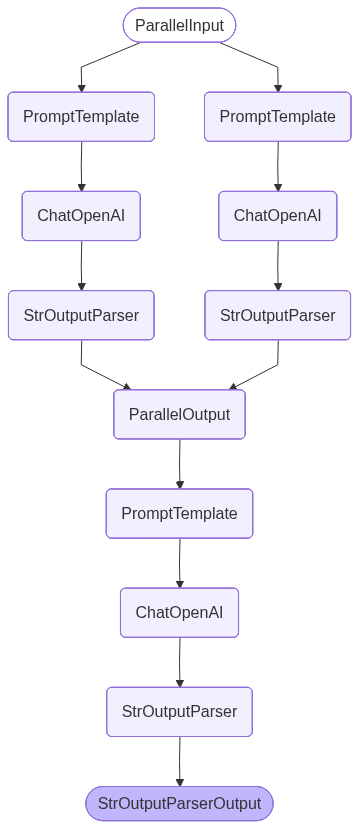

In [15]:
from IPython.display import Image, display

display(Image(chain.get_graph().draw_mermaid_png()))

### E se volessi portarmi fuori anche i risulati intermedi?

Per mostrare i risultati intermedi, come spesso accade in LangChain ho più possibilità.

Ad esempio restituire in output non solo il testo generato dal'ultima chain, ma restituire invece un dizionario che contiene sia l'outuput dell'ultima chain, sia gli output intermedi, che posso recuperarmi grazie al RunnablePassthrough

In [16]:
# Nota che abbiamo utilizzato due notazioni diverse nei due RunnableParallel. 
# La prima senza { } e con =
# La seconda con { } e con :
# Entrambi i metodi mi danno comunque come output un dizionario
chain = (
    RunnableParallel(
        history = history_prompt | llm | StrOutputParser(),
        story = story_prompt | llm | StrOutputParser()
    )  # {"history":"...", "story":"..."}
    | RunnableParallel(
        {
            "history" : RunnablePassthrough().pick("history"),
            "story" : RunnablePassthrough().pick("story"),
            "answer" : combine_prompt | llm | StrOutputParser()
        }
    ) #{"history":"...", "story":"...", "answer":""}
)

result = chain.invoke({"input": "Lecce"})
print(result)

{'history': 'Lecce è una città situata nel Salento, in Puglia, ed è conosciuta per la sua ricca storia e il suo patrimonio architettonico. Le origini di Lecce risalgono all\'epoca messapica, un popolo antico che abitava la regione. Successivamente, la città fu conquistata dai Romani, che la rinominarono "Lupiae" e ne svilupparono le infrastrutture, tra cui strade, teatri e acquedotti.\n\nNel corso dei secoli, Lecce passò sotto il dominio di vari popoli, tra cui i Bizantini, i Normanni, gli Svevi e gli Angioini. Durante il Rinascimento, la città visse un periodo di grande fioritura culturale e artistica, che contribuì alla creazione del suo caratteristico barocco leccese, un stile architettonico unico, visibile in numerose chiese e palazzi.\n\nNel XIX secolo, Lecce divenne un importante centro del movimento risorgimentale e, dopo l\'unità d\'Italia, continuò a crescere economicamente e culturalmente. Oggi, Lecce è una meta turistica popolare, grazie alla sua storia, alla sua architettur

In [17]:
print("HISTORY:")
print(result['history'])

print("\n============\n")

print("STORY:")
print(result['story'])

print("\n============\n")

print("ANSWER:")
print(result['answer'])

HISTORY:
Lecce è una città situata nel Salento, in Puglia, ed è conosciuta per la sua ricca storia e il suo patrimonio architettonico. Le origini di Lecce risalgono all'epoca messapica, un popolo antico che abitava la regione. Successivamente, la città fu conquistata dai Romani, che la rinominarono "Lupiae" e ne svilupparono le infrastrutture, tra cui strade, teatri e acquedotti.

Nel corso dei secoli, Lecce passò sotto il dominio di vari popoli, tra cui i Bizantini, i Normanni, gli Svevi e gli Angioini. Durante il Rinascimento, la città visse un periodo di grande fioritura culturale e artistica, che contribuì alla creazione del suo caratteristico barocco leccese, un stile architettonico unico, visibile in numerose chiese e palazzi.

Nel XIX secolo, Lecce divenne un importante centro del movimento risorgimentale e, dopo l'unità d'Italia, continuò a crescere economicamente e culturalmente. Oggi, Lecce è una meta turistica popolare, grazie alla sua storia, alla sua architettura barocca e

Oppure posso crearmi una __funzione di debug__ da inserire nel mezzo della catena per fare log intermedi

Importante notare come questa funzione prende in input un dizionario e restituisce in output un dizionario.
In questo modo possiamo includerla in mezzo alla nostra catana in cui sappiamo che un certo step precedente produrrà un dizionario e lo step successivo prenderà in input un dizionario

In [18]:
def debug_print(data: Dict[str, Any]) -> Dict[str, Any]:
    print(f"\n\nDebug - Dati correnti: {json.dumps(data, indent=2)}\n\n") # indent=2
    return data

In [19]:
# Nella catena qui sotto utilizziamo RunnableLambda per rendere la nostra funzione debug_print
# un oggetto Runnable in modo che possa essere inserita all'interno della catena
# Per completezza comunque è importante sapere che la catena funzionerebbe ugualmente mettendo
# solo debug_print invece che RunnableLambda(debug_print) 
# Questo perché LangChain si aspetta che l'elemento della catena in quel punto sia un Runnable oppure un Callable
# debug_print è una funzione python che è, per definzione, un oggetto Callable che dunque potrebbe già entrare nella catena
# ovviamente la funzione dovrà poi essere coerente con input ricevuto e output fornito
# Nelle versioni più vecchie di LangChain era necessario avere un Runnable, quindi usare RunnableLambda(debug_print) 
# aiuta ad assicurarci che tutto funzioni anche con versioni più vecchie di LangChain

# Creazione della catena composta
chain = (
    RunnableParallel(
        history= history_prompt | llm | StrOutputParser(),
        story= story_prompt | llm | StrOutputParser()
    ) # {"history":"...", "story":"..."}
    | RunnableLambda(debug_print) # {"history":"...", "story":"..."}
    | combine_prompt
    | llm
    | StrOutputParser()
)

# Uso della catena
result = chain.invoke({"input": "Lecce"})
print(result)



Debug - Dati correnti: {
  "history": "Lecce \u00e8 una citt\u00e0 situata nel Salento, in Puglia, e vanta una storia ricca e stratificata che risale a epoche antiche. Fondata dai Messapi, una popolazione indigenza, Lecce divenne un importante centro commerciale durante l'occupazione romana, assumendo il nome di \"Lupiae\". \n\nNel Medioevo, la citt\u00e0 sub\u00ec le dominazioni di diversi popoli, tra cui i Bizantini, i Normanni, e gli Svevi, per poi passare sotto il controllo degli Angioini e degli Aragonesi. Questo periodo vide la nascita di un significativo patrimonio architettonico, in particolare il barocco leccese, famoso per la sua ornamentazione.\n\nDurante il Rinascimento e nei secoli successivi, Lecce si svilupp\u00f2 ulteriormente, diventando un centro culturale e religioso. Nel XX secolo, la citt\u00e0 ha subito trasformazioni importanti, industrializzandosi e modernizzandosi, mantenendo per\u00f2 intatti i suoi tesori storici e artistici.\n\nOggi, Lecce \u00e8 nota per 